**Python script for predicting Ebola deaths,CFR and confirmed cases**

In [5]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('/content/train_data (1)(1).csv')

# Drop rows with missing latitude or longitude
data = data.dropna(subset=['Lat', 'Long_'])

# Feature Engineering: Create interaction features
data['Lat_Long'] = data['Lat'] * data['Long_']
data['Lat2'] = data['Lat'] ** 2
data['Long2'] = data['Long_'] ** 2

# Standardize features
scaler = StandardScaler()
data[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']] = scaler.fit_transform(data[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']])

# Train Deaths Prediction Model
death_train = data[data['Deaths'].notna()]
X_death_train = death_train[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']]
y_death_train = death_train['Deaths']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_death_train, y_death_train, test_size=0.2, random_state=42)

# Optimized XGBoost Model for Deaths
death_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.07,
    max_depth=9,
    subsample=0.7,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_lambda=1.5,
    reg_alpha=1.0,
    seed=42
)

# Early stopping with evaluation set (on validation data)
evals = [(X_val, y_val)]

# Fit the model and include early stopping for 50 rounds
# Optimized XGBoost Model for Deaths

death_model.fit(X_death_train, y_death_train)

# Train CFR Prediction Model
cfr_train = data[data['Case_Fatality_Ratio'].notna()]
X_cfr_train = cfr_train[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']]
y_cfr_train = cfr_train['Case_Fatality_Ratio']

# Optimized XGBoost Model for CFR
cfr_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_lambda=1.5,
    seed=42
)
cfr_model.fit(X_cfr_train, y_cfr_train)

# Load test data
test = pd.read_csv('/content/test_points.xlsx - Sheet1.csv')
test = test.dropna(subset=['Lat', 'Long_'])

# Apply the same feature transformations to test data
test['Lat_Long'] = test['Lat'] * test['Long_']
test['Lat2'] = test['Lat'] ** 2
test['Long2'] = test['Long_'] ** 2
test[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']] = scaler.transform(test[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']])

X_test = test[['Lat', 'Long_', 'Lat_Long', 'Lat2', 'Long2']]

# Predict Deaths and CFR
test['Predicted_Deaths'] = death_model.predict(X_test)
test['Predicted_CFR'] = cfr_model.predict(X_test)

# Ensure no negative CFR values
test['Predicted_CFR'] = test['Predicted_CFR'].apply(lambda x: max(x, 0.1))

# Calculate Confirmed Cases
test['Predicted_Confirmed_Cases'] = (test['Predicted_Deaths'] * 100) / test['Predicted_CFR']

# Generating output in CSV file
output = test[['Lat', 'Long_', 'Predicted_Deaths', 'Predicted_Confirmed_Cases', 'Predicted_CFR']]
output.columns = ['Lat', 'Long', 'Deaths', 'Confirmed', 'CFR']
output.to_csv('predictions.csv', index=False)

# Evaluate models on training data
train_death_preds = death_model.predict(X_death_train)
death_rmse = np.sqrt(mean_squared_error(y_death_train, train_death_preds))
death_r2 = r2_score(y_death_train, train_death_preds)

train_cfr_preds = cfr_model.predict(X_cfr_train)
cfr_rmse = np.sqrt(mean_squared_error(y_cfr_train, train_cfr_preds))
cfr_r2 = r2_score(y_cfr_train, train_cfr_preds)

print(f"Optimized Death Model - RMSE: {death_rmse}, R-squared: {death_r2}")
print(f"Optimized CFR Model - RMSE: {cfr_rmse}, R-squared: {cfr_r2}")


Optimized Death Model - RMSE: 3.85891606371665, R-squared: 0.9950403865969801
Optimized CFR Model - RMSE: 0.5128921154622219, R-squared: 0.9972815396612122


**Geographical Distribution of Predicted Deaths**

/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  class PathCollection(_CollectionWithSizes):


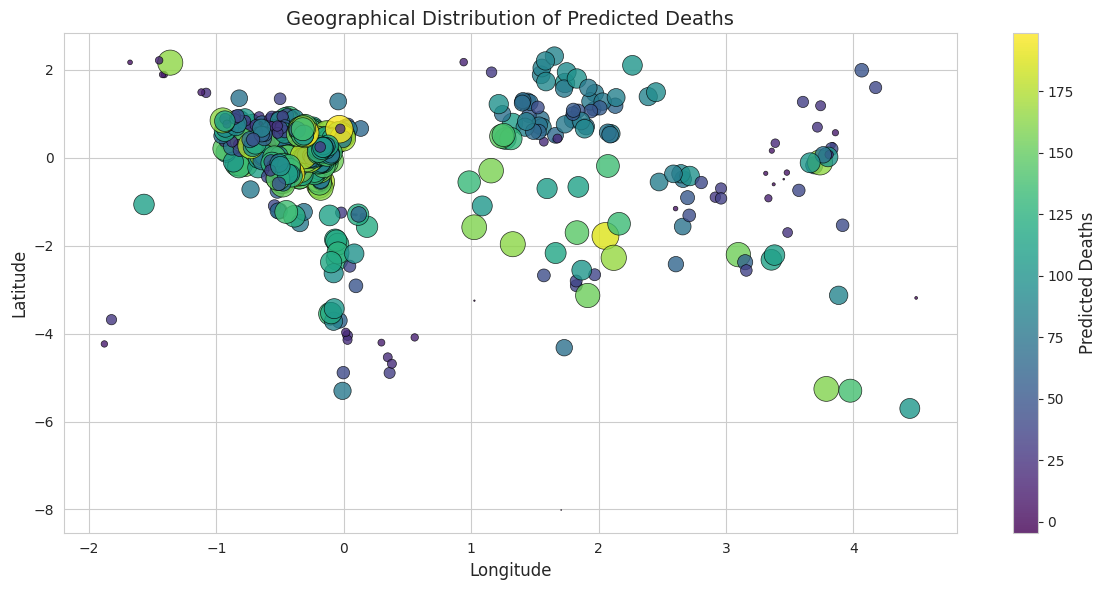

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
output = pd.read_csv('predictions.csv')  # Change filename if needed

# Ensure necessary columns exist
if not {'Lat', 'Long', 'Deaths'}.issubset(output.columns):
    raise ValueError("Dataset must contain 'Lat', 'Long', and 'Deaths' columns.")

# Set seaborn style
sns.set_style("whitegrid")

# Set up figure
plt.figure(figsize=(12,6))

# Normalize color mapping (vmin & vmax)
vmin, vmax = output['Deaths'].min(), output['Deaths'].max()

# Create scatter plot with improved clarity
sc = plt.scatter(
    output['Long'], output['Lat'],
    c=output['Deaths'], cmap='viridis',
    s=output['Deaths'] * 2,  # Increase size based on severity
    edgecolors="black", linewidth=0.5,
    alpha=0.8, vmin=vmin, vmax=vmax
)

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Predicted Deaths', fontsize=12)

# Labels and title
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Geographical Distribution of Predicted Deaths', fontsize=14)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


**Feature Correlation Heatmap**

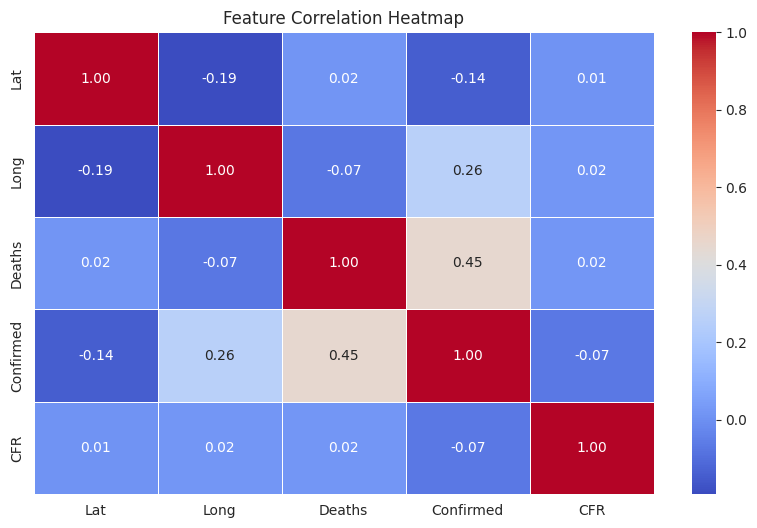

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("predictions.csv")  # Make sure the dataset includes more relevant features

# Check correlation matrix
correlation_matrix = df.corr()

# Plot heatmap for correlation analysis
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
